In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline

In [73]:
df=pd.read_csv('data/train.csv')

In [74]:
df.head()

,buying_price,maintainence_cost,number_of_doors,number_of_seats,luggage_boot_size,safety_rating,popularity
0,3,2,4,2,2,2,1
1,3,2,2,5,2,1,1
2,1,4,2,5,1,3,1
3,4,4,2,2,1,2,1
4,3,3,3,4,3,3,2


In [75]:
df.columns

Index(['buying_price', 'maintainence_cost', 'number_of_doors',
       'number_of_seats', 'luggage_boot_size', 'safety_rating', 'popularity'],
      dtype='object')

In [76]:
df.isnull().any()

buying_price         False
maintainence_cost    False
number_of_doors      False
number_of_seats      False
luggage_boot_size    False
safety_rating        False
popularity           False
dtype: bool

In [77]:
df.dtypes

buying_price         int64
maintainence_cost    int64
number_of_doors      int64
number_of_seats      int64
luggage_boot_size    int64
safety_rating        int64
popularity           int64
dtype: object

In [78]:
df.describe()

,buying_price,maintainence_cost,number_of_doors,number_of_seats,luggage_boot_size,safety_rating,popularity
count,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000
mean,2.532555,2.528256,3.493857,3.633292,1.987101,1.977887,1.348280
std,1.109626,1.116920,1.120557,1.257815,0.816520,0.819704,0.654766
min,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000
50%,3.000000,3.000000,3.000000,4.000000,2.000000,2.000000,1.000000
75%,4.000000,4.000000,4.250000,5.000000,3.000000,3.000000,2.000000
max,4.000000,4.000000,5.000000,5.000000,3.000000,3.000000,4.000000


## Analyzing 'buying price'

In [79]:
df['buying_price'].value_counts()

3    421
4    415
2    408
1    384
Name: buying_price, dtype: int64

## Analyzing 'popularity' 

In [80]:
df['popularity'].value_counts()

1    1185
2     359
3      44
4      40
Name: popularity, dtype: int64

In [81]:
# Upsampling minority classes
from sklearn.utils import resample
df_majority_1 = df[df.popularity==1]
df_minority_2 = df[df.popularity==2]
df_minority_3 = df[df.popularity==3]
df_minority_4 = df[df.popularity==4]

df_minority_2_ups = resample(df_minority_2, replace=True, n_samples=1185, random_state=524)
df_minority_3_ups = resample(df_minority_3, replace=True, n_samples=1185, random_state=524)
df_minority_4_ups = resample(df_minority_4, replace=True, n_samples=1185, random_state=524)

df_upsampled = pd.concat([df_majority_1, df_minority_2_ups, df_minority_3_ups, df_minority_4_ups])
df_upsampled['popularity'].value_counts()

3    1185
2    1185
1    1185
4    1185
Name: popularity, dtype: int64

In [82]:
summary=df.groupby('popularity')
summary.mean()

,buying_price,maintainence_cost,number_of_doors,number_of_seats,luggage_boot_size,safety_rating
popularity,,,,,,
1,2.643038,2.633755,3.454852,3.309705,1.933333,1.752743
2,2.434540,2.398329,3.587744,4.495822,2.108635,2.545961
3,1.318182,1.340909,3.613636,4.522727,1.886364,2.477273
4,1.475000,1.875000,3.675000,4.500000,2.600000,3.000000


## Correlation Matrix 

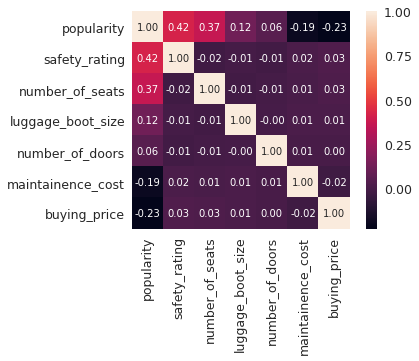

In [83]:
import seaborn as sns

corrmat = df.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'popularity')['popularity'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Modeling  

In [84]:
X=df_upsampled.iloc[:,0:6].values
y=df_upsampled.iloc[:,6].values

In [85]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = None)

In [86]:
# Fitting XGBoost to the Training set
from xgboost import XGBClassifier
classifier = XGBClassifier(max_depth=8, max_leaf_nodes=256, learning_rate=0.1, subsample=0.6, n_estimators=1000, nthread=4, colsample_bytree=0.6)
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, max_leaf_nodes=256, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=4, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6)

In [87]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [88]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [89]:
cm

array([[235,   0,   1,   0],
       [  0, 218,   0,   0],
       [  0,   0, 258,   0],
       [  0,   0,   0, 236]])

In [90]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 5)
accuracies.mean()
accuracies.std()

0.0040970481262516002

In [91]:
accuracies.mean()

0.99603802088040394

## Predicting the Test Data 

In [92]:
df_test=pd.read_csv('data/test.csv')

In [93]:
df_test.head()

,4,1,2,2.1,2.2,2.3
0,2,1,3,4,3,2
1,4,4,2,5,1,2
2,4,3,3,2,2,2
3,4,2,2,4,3,2
4,4,3,5,2,3,3


In [94]:
X_test=df_test.iloc[:,:].values

In [95]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [96]:
y_pred

array([2, 1, 1, 2, 1, 4, 3, 4, 1, 3, 3, 4, 3, 1, 3, 1, 3, 1, 2, 2, 3, 3, 4,
       2, 3, 2, 4, 2, 3, 2, 1, 3, 4, 4, 1, 3, 4, 1, 4, 4, 1, 3, 2, 3, 1, 2,
       2, 3, 1, 1, 2, 2, 1, 4, 4, 2, 1, 4, 2, 4, 2, 3, 3, 4, 2, 4, 1, 1, 2,
       4, 4, 2, 1, 2, 1, 1, 4, 2, 3, 2, 4, 3, 3, 4, 3, 4, 2, 4, 2, 1, 2, 2,
       2, 4, 1, 2, 4, 4, 1])

# Saving the file 

In [97]:
result=pd.read_csv('update.csv')

In [98]:
result

,popularity


In [99]:
result['popularity']=y_pred

In [100]:
result.head()

,popularity
0,2
1,1
2,1
3,2
4,1


In [101]:
result.to_csv('prediction.csv', sep=',',index=False, header=False)